####   1.Анализ производительности graph-500 на локальной машине


Определимся сначала с параметрами теста. В ходе предварительных запусков, оказалось, что на локальной машинке с 4 процессорами увеличение SСALE приводит к колоссальному увеличению времени работы (т.е. для 26 16 - всего лишь Toy размер, дождаться окончания хоть одной итерации не удалось). В итоге, я остановился на стандартном размере SCALE:16 EDGE_FACTOR:16 и запускал mpi-версию в 4 потока:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;<b>mpi-run -np 4 ./graph500_mpi_simple 16 16</b><br>
В результате, по итогам 64 итераций:

<pre>SCALE:                          16
edgefactor:                     16
NBFS:                           64
graph_generation:               0.546302
num_mpi_processes:              4
construction_time:              0.144039
min_time:                       0.147475
firstquartile_time:             0.179075
median_time:                    0.183782
thirdquartile_time:             0.188256
max_time:                       0.232297
mean_time:                      0.183914
stddev_time:                    0.0144824
min_nedge:                      1048570
firstquartile_nedge:            1048570
median_nedge:                   1048570
thirdquartile_nedge:            1048570
max_nedge:                      1048570
mean_nedge:                     1048570
stddev_nedge:                   0
min_TEPS:                       4.51393e+06
firstquartile_TEPS:             5.56993e+06
median_TEPS:                    5.7055e+06
thirdquartile_TEPS:             5.85547e+06
max_TEPS:                       7.11013e+06
harmonic_mean_TEPS:             5.70142e+06
harmonic_stddev_TEPS:           56563.9
min_validate:                   3.30918
firstquartile_validate:         3.99619
median_validate:                4.10362
thirdquartile_validate:         4.21789
max_validate:                   4.51817
mean_validate:                  4.08953
stddev_validate:                0.234609</pre>

То есть, по итогам теста, производительность составила: <b>median_TEPS: 5.7055e+06</b>, то есть <b>0.0057055 GTEPS</b>, что в 4 раза хуже последнего (192) места в рейтинге http://www.graph500.org/results_jul_2015


### 3. Определение параметров графа Кронекера

&nbsp;&nbsp;&nbsp;&nbsp;Для того, чтобы определить параметры графа, требуется сперва выписать все его рёбра. Возьмём за основу программку <b>make-edgelist</b> (компонент graph-500 reference code) и слегка её модифицируем: [make-edgelist.c](make-edgelist.c)<br>
&nbsp;&nbsp;&nbsp;&nbsp;В результате, от исходного назначения утилиты не осталось и следа и в stdout она выводит данные в следующем формате:

<pre>SCALE, 2^16 - 1
v1 v2
v3 v4
.....</pre>

Заметим, что при генерации графа мы будем использовать параметры: scale=10 и edge_factor=16

<pre>./graph500-2.1.4/make-edgelist -s 10 -e 16 > graph.10-16.data</pre>

Теперь проанализируем параметры этого графа, считав [graph.10-16.data](graph.10-16.data) для этого воспользуемся библиотекой <b>NetworkX</b>

In [1]:
import networkx as nx

In [174]:
def graph_from_file(filename):
    DG = nx.DiGraph()
    with open(filename, 'r') as file:
        header = file.readline()
        scale, N = map(int, header.strip().split())
        # DG.add_nodes_from(range(N))
        for line in file:
            DG.add_edge(*map(int, line.strip().split()))
    return DG

In [175]:
graph = graph_from_file('graph.10-16.data')

In [155]:
graph.number_of_nodes(), graph.number_of_edges()

(887, 10652)

Теперь посчитаем первую интересующую нас характеристику - диаметр графа:

In [156]:
nx.diameter(graph)

NetworkXError: Graph not connected: infinite path length

Наш граф - несвязный! В таком случае, попробуем разбить его на компоненты свзяности. Средствами NetworkX разобьем его на слабосвязные компоненты - так получим более адекватное представление о связях в нём

In [165]:
nx.is_weakly_connected(graph) # проверим хотя бы на слабосвязность

True

Попробуем посмотреть, сколько тут сильносвязных компонент

In [158]:
nx.number_strongly_connected_components(graph) == graph.order()

True

Тогда попробуем посчитать "Почти диаметр" - максимальный путь != inf

In [2]:
def eccentricity_finite(G):
    """Return the eccentricity of nodes in G.

    The eccentricity of a node v is the maximum distance from v to
    all other nodes in G. Ignore infinite
    """
    order=G.order()

    e={}
    for n in G.nbunch_iter():
        length=nx.single_source_shortest_path_length(G,n)            
        e[n]=max(length.values())
    return e

In [3]:
def diameter(G):
    return max(eccentricity_finite(G).values())

In [161]:
diameter(graph)

9

Аналогично посчитаем среднее расстояние между вершинами

In [4]:
def avg_path_len(G):
    numOfPath = 0
    sumPathLen = 0
    for n in G.nbunch_iter():
        length = nx.single_source_shortest_path_length(G,n)            
        sumPathLen += sum(list((length.values())))
        numOfPath += len(length)
    return float(sumPathLen) / numOfPath

In [164]:
avg_path_len(graph)

2.5147304750044475

И построим гистограмму #(n,d)

In [172]:
from collections import Counter
import pylab
import operator

def printGraphDegreeDistribution(gr):
    cnt = Counter()
    for v in gr.degree().values():
        cnt[v] += 1
    #sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(0))
    max_degree = max(list(cnt.keys()))
    out_bins = []
    out_values = []
    for i in range(1, max_degree + 1):
        out_bins.append(i)
        out_values.append(cnt[i])
    pylab.plot(out_bins, out_values)
    pylab.xlabel('degree')
    pylab.ylabel('number')
    pylab.xticks(range(1, max_degree + 1, 9))

In [173]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


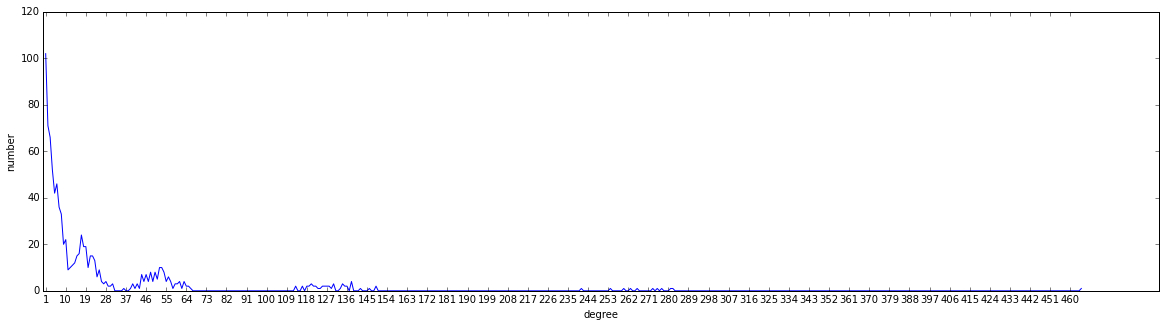

In [176]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

printGraphDegreeDistribution(graph)

По данному графику можно увидеть, что большинство связей имеют небольшую длину, что совпадает с мнением об адекватности использования графа кронекера для иллюстрации социальных связей

Более точно, получив параметры модели, мы узнали, что <br>а) наш граф имеет рапределение степеней вершин по закону, вполне похожем на степенной<br>
б) То есть, несмотря на исключительную разреженность, диаметр графа(не учитывая недостижимые вершины) = 9 <br>в) Средняя длина пути между вершинами - всего 2.5147304750044475 (опять же, исключая недостижимые). При этом, весь наш граф - есть одна компонента связности

Как выяснилось, на самом деле, граф стоит рассматривать как неориентированный - это сильно упрощает жизнь и даёт менее смещённые результаты (по крайней мере что касается диаметра, средней длины и расчёта средней длины пути)

In [167]:
def undir_graph_from_file(filename):
    G = nx.Graph()
    with open(filename, 'r') as file:
        header = file.readline()
        scale, N = map(int, header.strip().split())
        # DG.add_nodes_from(range(N))
        for line in file:
            G.add_edge(*map(int, line.strip().split()))
    return G

In [169]:
undir_graph = undir_graph_from_file('graph.10-16.data')

Поскольку направленный граф - слабосвязный, то ненаправленный будет связным

In [170]:
nx.diameter(undir_graph)

5

5 - число, куда более подходящее по теорему о 6 рукопожатиях!

In [173]:
avg_path_len(undir_graph) # средняя длина пути по прежнему ~ такая же

2.421102000714314

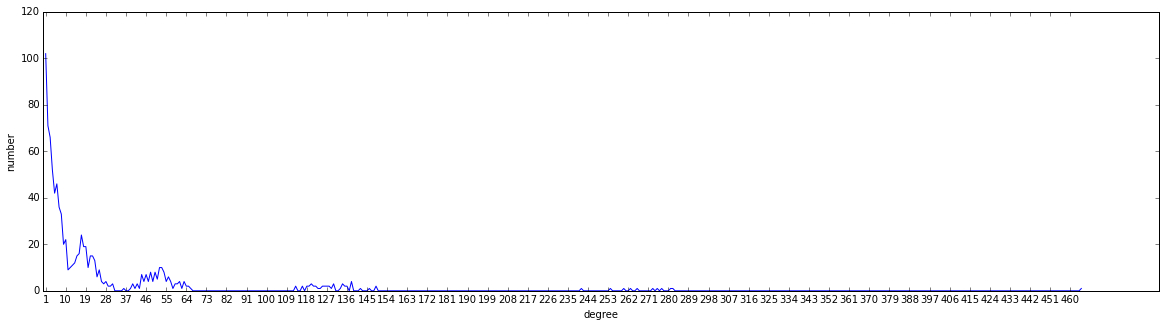

In [175]:
printGraphDegreeDistribution(undir_graph)

Распредение степеней такое же - т.к для оргргафа в качестве степени бралась deg(in) + deg(out)

### 4. Генерация и определение параметров графа в модели Боллобаша-Риордана

Сначала напишем функцию генерации графа, а затем с помощью вышерассмотренных методов проанализируем его параметры

In [121]:
import random
from itertools import chain

def gen_graph(n, m):
    def gen_m1(n):
        def extend_m1(g, vn):
            acc = 0
            rand = random.random()
            lst = [(vn, 1.0)]
            lst.extend(g.degree().items())
            for nodeId, deg in lst:
                acc += float(deg)/(2*vn-1)
                if (rand < acc):
                    ov = nodeId
                    break
            g.add_edge(vn, ov)
            return g
        G = nx.Graph()
        for vn in range(1, n + 1):
            G = extend_m1(G, vn)
        return G
    g = gen_m1(n*m)
    #now it's time to unite g!
    G = nx.Graph()
    for node in range(1, n*m + 1, m):
        bunch = range(node, node + m)
        bunch_edges = list(
            filter(lambda x: x[0] in bunch or x[1] in bunch,
            g.edges()))
        bunch_edges = [x[0] if x[0] not in bunch else x[1] for x in bunch_edges]
        bunch_edges = tuple(bunch_edges)
        bunch = tuple(bunch)
        G.add_node(bunch)
        for G_node in G.nodes():
            tmp = [_ for _ in G_node if _ in bunch_edges]
            if len(tmp) > 0:
                G.add_edge(bunch, G_node)
    return G

In [124]:
g1000_10 = gen_graph(1000,10)

In [136]:
g100_100 = gen_graph(100,100)

In [137]:
g500_20 = gen_graph(500,20)

In [123]:
g_10000_1 = gen_graph(10000, 1)

In [138]:
g_1000_1 = gen_graph(1000, 1)

Отмечу пару нюансов<br>
а) В ходе попыток написания генератора, я столкнулся с тем, что не знаю как (на первом этапе), добавлять вершину быстрее, чем за линию. В этом варианте, даже банальное (без второй фазы) g(10000, 1) - мой предел по порядку, т.к. g(10^5, 1) считается непозволительно долго<br>
б) в связи с этим, я ограничен n\*m = 10000<br>
в) после неуспеха с первым этапом, оптимизацией второго я не занимался в принципе - поэтому там, наверное, просто дикая сложность<br>
г) при расчёте средней длины пути некоторое смещение будут давать петли (из графа кронекера я их удалял), интересно посмотреть насколько отличается средняя длина в случаях учёта и неучёта петель (распределение степеней будет неизменным, если убрать дуги - просто степень некоторых вершин уменьшится на 2, что будет практически незаметно на графике)

P.S. На этом этапе выяснилось, что считать статистику по графу на 10к вершин слишком накладно, от варианта потестировать g(10000,1) вершин пришлось отказаться, попробуем вместо него что-то в духе g(1000,2)/g(1000,4) - потому что для g(1000,1) результаты, в целом, интересные

In [131]:
def remove_loops(G):
    copy = nx.Graph()
    copy.add_nodes_from(G.nodes())
    copy.add_edges_from([_ for _ in G.edges() if _[0] != _[1]])
    return copy

In [141]:
g1000_10_nl = remove_loops(g1000_10)
g100_100_nl = remove_loops(g100_100)
g500_20_nl = remove_loops(g500_20)
g_10000_1_nl = remove_loops(g_10000_1)
g_1000_1_nl = remove_loops(g_1000_1)

In [150]:
g1000_2 = gen_graph(1000,2)
g_1000_2_nl = remove_loops(g1000_2)

In [158]:
g1000_4 = gen_graph(1000,4)
g_1000_4_nl = remove_loops(g1000_4)

In [161]:
with_loops = [('g1000_10', g1000_10),
              ('g100_100', g100_100),
              ('g500_20', g500_20),
              ('g_1000_1', g_1000_1),
              ('g_1000_2', g1000_2),
              ('g_1000_4', g1000_4)
             ]

In [163]:
no_loops = [('g1000_10_nl', g1000_10_nl),
            ('g100_100_nl', g100_100_nl),
            ('g500_20_nl', g500_20_nl),
            ('g_1000_1_nl', g_1000_1_nl),
            ('g_1000_2_nl', g_1000_2_nl),
            ('g_1000_4_nl', g_1000_4_nl)
           ]

In [164]:
for name, graph in with_loops:
    print('{} is connected: {}'.format(name, nx.is_connected(graph)))
    print('{} diameter is: {}'.format(name, diameter(graph)))

g1000_10 is connected: True
g1000_10 diameter is: 4
g100_100 is connected: True
g100_100 diameter is: 2
g500_20 is connected: True
g500_20 diameter is: 3
g_1000_1 is connected: False
g_1000_1 diameter is: 15
g_1000_2 is connected: True
g_1000_2 diameter is: 8
g_1000_4 is connected: True
g_1000_4 diameter is: 5


Забавный факт! Если m = 1, то действительно, граф может быть несвязным, и модель в плане диаметра сильно выбивается от стандарта в "6 рукопожатий", с другой стороны, на таком, не очень большом графе ( не более 1000 вершинок ), можно добиться нормальных результатов, просто сгруппировав вершинки по 4 (по 2 тоже неплохо, но ещё не дотягивает до 6). Уменьшение отношения n / m даёт ещё меньшие значения для диаметра. В целом, думаю, что отношение n / m ~ 250 -наиболее удачно. Ради интереса, посмотрим на граф g(500,2)

In [167]:
g500_2 = gen_graph(1000,4)
print('g500_2 is connected: {}'.format(nx.is_connected(g500_2)))
print('g500_2 diameter: {}'.format(diameter(g500_2)))

g500_2 is connected: True
g500_2 diameter: 5


Действительно, диаметр остался прежним! Успех! Сравним теперь среднюю длину путей в графах с петлями и без них

In [168]:
for wl, wol in zip(with_loops, no_loops):
    print('{} avg path len = {} and {} avg path len = {}'.format(
        wl[0], avg_path_len(wl[1]), wol[0], avg_path_len(wol[1])))

g1000_10 avg path len = 2.450884 and g1000_10_nl avg path len = 2.450884
g100_100 avg path len = 1.2844 and g100_100_nl avg path len = 1.2844
g500_20 avg path len = 1.971032 and g500_20_nl avg path len = 1.971032
g_1000_1 avg path len = 5.572662167339601 and g_1000_1_nl avg path len = 5.572662167339601
g_1000_2 avg path len = 4.12196 and g_1000_2_nl avg path len = 4.12196
g_1000_4 avg path len = 3.14933 and g_1000_4_nl avg path len = 3.14933


Никакой разницы и нет. Видимо, дело в том, что я всё же слегка неправильно интерпретировал работу функции поиска кратчайших путей до вершин в своих предварительных тестах + результаты весьма похожи на то что мы видели в графе Кронекера

Ну и распечатаем графики распределений чтобы на них полюбоваться!

In [181]:
def printGraphDegreeDistribution_modified(gr):
    cnt = Counter()
    for v in gr.degree().values():
        cnt[v] += 1
    #sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(0))
    max_degree = 123 # for experiment :)
    out_bins = []
    out_values = []
    for i in range(1, max_degree + 1):
        out_bins.append(i)
        out_values.append(cnt[i])
    pylab.plot(out_bins, out_values)
    pylab.xlabel('degree')
    pylab.ylabel('number')
    pylab.xticks(range(1, max_degree + 1, 9))
    

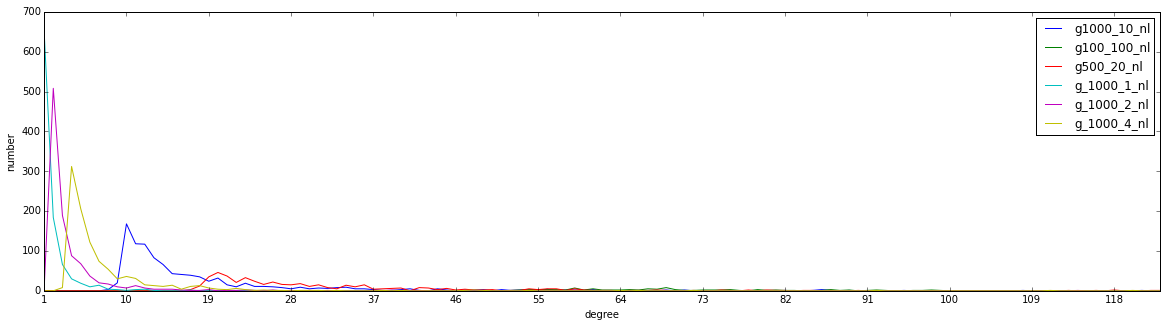

In [183]:
for name, graph in no_loops:
    printGraphDegreeDistribution_modified(graph)
pyplot.legend(list(map(lambda x: x[0], no_loops)))

&nbsp;&nbsp;&nbsp;&nbsp;Я слегка обрезал графи (т.к были вершины с очень большой степенью - хабы, которых было очень мало и это было практически незаметно на графике). В общем и целом видно, что степенной закон распределения степеней вершин выполняется. Напоследок выведем максимальную степень вершины в графах и отношение количества вершин со степенью > 20 ко всему числу вершин в графе  <br>
&nbsp;&nbsp;&nbsp;&nbsp;У всех графов тут (как и у Кронекера), есть небольшой мини-пик в районе 5-10, не совсем понимаю, чем такое объяснить

In [187]:
for name, g in no_loops:
    print('for {} max degree = {}'.format(
        name, max(graph.degree().values())))

for g1000_10_nl max degree = 129
for g100_100_nl max degree = 129
for g500_20_nl max degree = 129
for g_1000_1_nl max degree = 129
for g_1000_2_nl max degree = 129
for g_1000_4_nl max degree = 129


Вот это совпадение о_О

In [192]:
float(len([_ for _ in g_1000_4_nl.degree().values() if _ > 20])) / g_1000_4_nl.order()

0.035

Всего 3.5%. Думаю, этого вполне достаточно, чтобы заключить, что данная модель хорошо подходит для описания графа интернета